In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

### `Load data Numericals - Chi2, Categorical and Target`

In [2]:
numericals = pd.read_csv('data/numericals_chi2.csv')
categoricals = pd.read_csv('data/categorical_cleaned.csv')
targets = pd.read_csv('data/target.csv')

print(f"Numericals shape: {numericals.shape}")
print(f"Categoricals shape: {categoricals.shape}")
print(f"Targets shape: {targets.shape}")

Numericals shape: (95412, 13)
Categoricals shape: (95410, 22)
Targets shape: (95412, 2)


### `Detect best n_neighbors for KNeighborsClassifier`

#### `Helper functions`

In [4]:
def oversample():
    target = targets[['TARGET_B']]

    target_b_0 = target[target['TARGET_B'] == 0]
    target_b_1 = target[target['TARGET_B'] == 1]

    target_b_1_oversampled = resample(target_b_1, replace=True, n_samples=len(target_b_0))
    target_b_oversampled = pd.concat([target_b_0, target_b_1_oversampled], axis=0)

    full_df = pd.concat([target_b_oversampled, numericals, categoricals], axis=1).dropna(axis=0).sample(frac=1, random_state=10)

    return full_df['TARGET_B'], full_df.drop('TARGET_B', axis=1)


def plot_n_neighbors(should_oversample):
    full_df = pd.concat([targets[['TARGET_B']], numericals, categoricals], axis=1).dropna(axis=0).sample(frac=1, random_state=10)

    y = full_df['TARGET_B']
    X = full_df.drop('TARGET_B', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

    if should_oversample == True:
        y_train, X_train = oversample()

    # Scaling data = X_train
    X_train_transformer = MinMaxScaler().fit(X_train)
    X_train_normalized = X_train_transformer.transform(X_train)
    X_train_normalized = pd.DataFrame(X_train_normalized)

    # Scaling data = X_test
    X_test_transformer = MinMaxScaler().fit(X_test)
    X_test_normalized = X_test_transformer.transform(X_test)
    X_test_normalized = pd.DataFrame(X_test_normalized)

    # Try to detect best n_neighbors for KNeighborsRegressor

    train_scores = []
    test_scores = []
    for k in range(2,10):
        print(f"Testing k='{k}'.")
        model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        model.fit(X_train, y_train)
        train_scores.append(model.score(X_train, y_train))
        test_scores.append(model.score(X_test, y_test))


    # Plot n_neighbors results for KNeighborsRegressor 

    plt.figure(figsize=(10,6))
    plt.plot(range(2,10),test_scores,color = 'blue', linestyle='dashed',
            marker='o', markerfacecolor='red', markersize=10)
    plt.title('R2-scores vs. K Value')
    plt.gca().invert_yaxis()
    plt.xlabel('K')
    plt.ylabel('Accuracy')
    plt.show()

#### `Plot n_neighbors for imbalanced TARGET_B`

In [ ]:
plot_n_neighbors(should_oversample=False)

In [ ]:
# Best n_neighbors for imbalanced TARGET_B seems 6

#### `Plot n_neighbors for oversampled TARGET_B`

In [ ]:
plot_n_neighbors(should_oversample=True)

In [ ]:
# Best n_neighbors for oversampled TARGET_B seems 2 or 3

### `Compare Algorithms`

In [ ]:
models_to_test_imbalanced = [
    DecisionTreeClassifier(),
    KNeighborsClassifier(n_neighbors=6, n_jobs=-1),
    LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1)
]

In [ ]:
models_to_test_oversampled = [
    DecisionTreeClassifier(),
    KNeighborsClassifier(n_neighbors=2, n_jobs=-1),
    KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
    LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1)
]

In [17]:
def compare_models(models, should_oversample):
    for model in models:

        print(f"====== {model} ======")

        full_df = pd.concat([targets[['TARGET_B']], numericals, categoricals], axis=1).dropna(axis=0).sample(frac=1, random_state=10)

        y = full_df['TARGET_B']
        X = full_df.drop('TARGET_B', axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

        if should_oversample == True:
            y_train, X_train = oversample()

        # Scaling data = X_train
        X_train_transformer = MinMaxScaler().fit(X_train)
        X_train_normalized = X_train_transformer.transform(X_train)
        X_train_normalized = pd.DataFrame(X_train_normalized)

        # Scaling data = X_test
        X_test_transformer = MinMaxScaler().fit(X_test)
        X_test_normalized = X_test_transformer.transform(X_test)
        X_test_normalized = pd.DataFrame(X_test_normalized)

        model.fit(X_train_normalized, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test_normalized)

        # Calculate the accuracy of the model
        scores = cross_val_score(model, X_train_normalized, y_train, cv=10)
        # Print the mean and standard deviation of the scores
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        
        accuracy = accuracy_score(y_test, y_pred)
        print(f"accuracy: {accuracy}")
        print("precision: ",precision_score(y_test, y_pred))
        print("recall: ",recall_score(y_test, y_pred))
        print("f1: ",f1_score(y_test, y_pred))

        # create confusion matrix
        matrix = confusion_matrix(y_test, y_pred)

        # display confusion matrix
        plt.imshow(matrix, cmap='Blues')
        plt.colorbar()
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        # set tick marks for x-axis and y-axis
        plt.xticks([0,1])
        plt.yticks([0,1])
        # set the tick labels for x-axis and y-axis
        plt.xticks(ticks=[0,1], labels=['Negative', 'Positive'])
        plt.yticks(ticks=[0,1], labels=['Negative', 'Positive'])

        # loop through the cells of the matrix and add the values
        for i in range(2):
            for j in range(2):
                plt.text(j, i, matrix[i, j], ha='center', va='center', color='black', fontsize=20)
        plt.show()

#### `Imbalanced TARGET_B`

In [ ]:
compare_models(models=models_to_test_imbalanced, should_oversample=False)

#### `Oversampled TARGET_B`

In [ ]:
compare_models(models=models_to_test_oversampled, should_oversample=True)

In [ ]:
# DecisionTreeClassifier with oversampled TARGET_B performs better in general

### `Looking for best parameters for DecisionTreeClassifier - Hyperparameter search`

In [5]:
max_depth_choices= [3,10,None]
criterion_choices = ['gini', 'entropy']
splitter_choices = ['best', 'random']
min_samples_split_choices = [2,10]
min_samples_leaf_choices = [1,2,10]
max_features_choices = [None,'auto', 'sqrt', 'log2']
class_weight_choices = [None, 'balanced']

grid = {
    'max_depth': max_depth_choices,
    'criterion': criterion_choices,
    'splitter': splitter_choices,
    'min_samples_split': min_samples_split_choices,
    'min_samples_leaf': min_samples_leaf_choices,
    'max_features': max_features_choices,
    'class_weight': class_weight_choices
}

model = DecisionTreeClassifier(random_state=10)
grid_search_decision_tree_classifier = GridSearchCV(estimator = model, param_grid = grid, cv = 5, n_jobs=-1)


full_df = pd.concat([targets[['TARGET_B']], numericals, categoricals], axis=1).dropna(axis=0).sample(frac=1, random_state=10)

y = full_df['TARGET_B']
X = full_df.drop('TARGET_B', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

y_train, X_train = oversample()

# Scaling data = X_train
X_train_transformer = MinMaxScaler().fit(X_train)
X_train_normalized = X_train_transformer.transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized)

# Scaling data = X_test
X_test_transformer = MinMaxScaler().fit(X_test)
X_test_normalized = X_test_transformer.transform(X_test)
X_test_normalized = pd.DataFrame(X_test_normalized)

grid_search_decision_tree_classifier.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=10), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 10, None],
                         'max_features': [None, 'auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 10],
                         'min_samples_split': [2, 10],
                         'splitter': ['best', 'random']})

In [6]:
grid_search_decision_tree_classifier.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'splitter': 'best'}

In [7]:
grid_search_decision_tree_classifier.best_score_

0.9706707336494033

### `Looking for best parameters for LogisticRegression - Hyperparameter search`

In [8]:
penalty_choices= [None,'l2','l1','elasticnet']
class_weight_choices = [None, 'balanced']
solver_choices = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
multi_class_choices = ['auto', 'ovr', 'multinomial']

grid = {
    'penalty': penalty_choices,
    'class_weight': class_weight_choices,
    'solver': solver_choices,
    'multi_class': multi_class_choices
}

model = LogisticRegression(random_state=10)
grid_search_logistic_regression = GridSearchCV(estimator = model, param_grid = grid, cv = 5, n_jobs=-1)


full_df = pd.concat([targets[['TARGET_B']], numericals, categoricals], axis=1).dropna(axis=0).sample(frac=1, random_state=10)

y = full_df['TARGET_B']
X = full_df.drop('TARGET_B', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

y_train, X_train = oversample()

# Scaling data = X_train
X_train_transformer = MinMaxScaler().fit(X_train)
X_train_normalized = X_train_transformer.transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized)

# Scaling data = X_test
X_test_transformer = MinMaxScaler().fit(X_test)
X_test_normalized = X_test_transformer.transform(X_test)
X_test_normalized = pd.DataFrame(X_test_normalized)

grid_search_logistic_regression.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=10), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': [None, 'l2', 'l1', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']})

In [9]:
grid_search_logistic_regression.best_params_

{'class_weight': 'balanced',
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'liblinear'}

In [10]:
grid_search_logistic_regression.best_score_

0.5807112458147083

### `Looking for best parameters for KNeighborsClassifier - Hyperparameter search`

In [13]:
n_neighbors_choices = [2, 3, 4, 5, 6]
weights_choices = ['uniform', 'distance', None]
algorithm_choices = ['auto', 'ball_tree', 'kd_tree', 'brute']
p_choices = [1, 2]

grid = {
    'n_neighbors': n_neighbors_choices,
    'weights': weights_choices,
    'algorithm': algorithm_choices,
    'p': p_choices
}

model = KNeighborsClassifier(n_jobs=-1)
grid_search_k_neighbors_classifier = GridSearchCV(estimator = model, param_grid = grid, cv = 5, n_jobs=-1)


full_df = pd.concat([targets[['TARGET_B']], numericals, categoricals], axis=1).dropna(axis=0).sample(frac=1, random_state=10)

y = full_df['TARGET_B']
X = full_df.drop('TARGET_B', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

y_train, X_train = oversample()

# Scaling data = X_train
X_train_transformer = MinMaxScaler().fit(X_train)
X_train_normalized = X_train_transformer.transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized)

# Scaling data = X_test
X_test_transformer = MinMaxScaler().fit(X_test)
X_test_normalized = X_test_transformer.transform(X_test)
X_test_normalized = pd.DataFrame(X_test_normalized)

grid_search_k_neighbors_classifier.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [2, 3, 4, 5, 6], 'p': [1, 2],
                         'weights': ['uniform', 'distance', None]})

In [14]:
grid_search_k_neighbors_classifier.best_params_

{'algorithm': 'kd_tree', 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}

In [15]:
grid_search_k_neighbors_classifier.best_score_

0.9692070735466052

### `Compare DecisionTreeClassifier and KNeighborsClassifier with best parameters`

====== DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_features='auto', min_samples_split=10) ======
Accuracy: 0.97 (+/- 0.00)
accuracy: 0.9503196729902526
precision:  0.5088082901554404
recall:  0.5088082901554404
f1:  0.5088082901554404


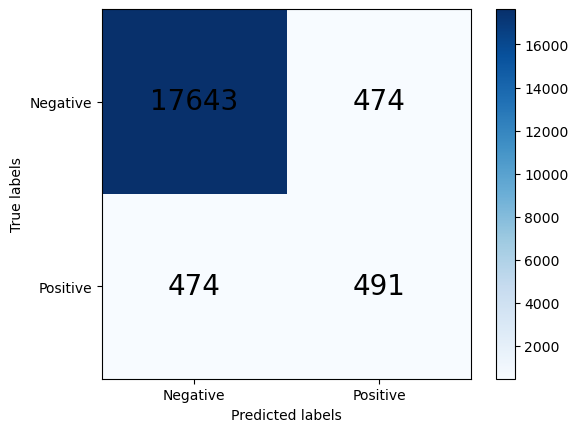

====== KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=2, p=1) ======


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Accuracy: 0.97 (+/- 0.00)
accuracy: 1.0
precision:  1.0
recall:  1.0
f1:  1.0


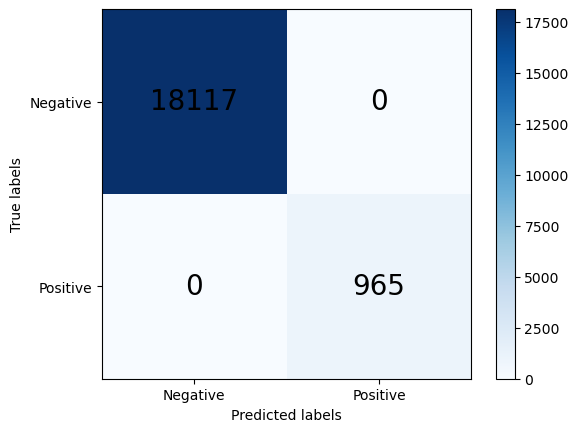

In [18]:
classification_models_to_test_oversampled = [
    DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=10, splitter='best'),
    KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2, p=1, weights='uniform', n_jobs=-1)
]

compare_models(models=classification_models_to_test_oversampled, should_oversample=True)